In [180]:

%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sklearn.decomposition, sklearn.cluster
from nheatmap import nhm, scripts
import matplotlib.pyplot as plt
import matplotlib as mpl
import scanpy as sc

# create a color dictionary for tissues
def tissue_colors():
    
    tissue_color_dict = {'Bladder': '#e7969c',
             'Blood': '#d6616b',
             'Bone_Marrow': '#cedb9c',
             'Eye': '#c7ea46',#"#00ff7f",
             'Fat': '#e7cb94',
             'Heart': '#ff0800',
             'Kidney': '#7b4173',
             'Large_Intestine': '#31a354',
             'Liver': '#000080',
             'Lung': '#3182bd',
             'Lymph_Node': '#8c6d31',
             'Mammary':'#ce6dbd',
             'Muscle': '#e7ba52',
             'Pancreas': '#fd8d3c',
             'Prostate':'#637939',#'#a55194',#
             'Salivary_Gland':'#622a0f',
             'Skin': '#de9ed6',
             'Small_Intestine': '#6baed6',
             'Spleen': '#393b79',
             'Thymus': '#9c9ede',
             'Tongue':'#b5cf6b',
             'Trachea': '#969696',
             'Uterus':'#c64b8c',#'#ff0090',
             'Vasculature': '#843c39'}
    
    return tissue_color_dict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [177]:
cell_type = 'macrophage'
df = pd.read_csv(cell_type + 'tissue_distinguishing_genes.csv', index_col=0)
# cannot currently read this object because it kills my kernel
gene_set = df.iloc[:,0]
adata = sc.read_h5ad('../../data/TSP1_TSP15_scvi_donor-method_normalized-log1p-scaled_annotated.h5ad', backed='r+')

adata = adata[adata.obs.cell_ontology_class == cell_type]

adata = adata.to_memory()
adata = adata[~adata.obs.tissue.isin(['Salivary_Gland', 'Heart', 'Eye'])]

subset = True 
if subset:
    adata = adata[:,adata.var.index.isin(gene_set)]

def _pp(adata, log, normalize, remove_dissociation):
    if normalize:
        sc.pp.normalize_total(adata)
    if log:
        sc.pp.log1p(adata, chunk_size=50000)
        adata.raw = adata
    if remove_dissociation:
    #mouse2human = pd.read_csv('../metadata/mouse2human.csv')
        dissociation_genes = pd.read_csv('../metadata/Mouse2Human_dissociation_genes.csv')
        adata.var['not_dissociation_gene'] = ~adata.var.index.isin(dissociation_genes['Human gene name'])
        adata = adata[:, adata.var.not_dissociation_gene == True]
    highly_variable = True
    if highly_variable:
        sc.pp.highly_variable_genes(adata, n_top_genes=200)
        adata = adata[:,adata.var.highly_variable == True]

    return adata

adata = _pp(adata, True, True, False)

/home/michaelswift/miniconda3/envs/scirpy/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


/home/michaelswift/miniconda3/envs/scirpy/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:845: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


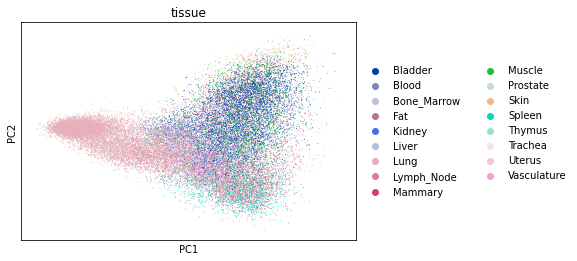

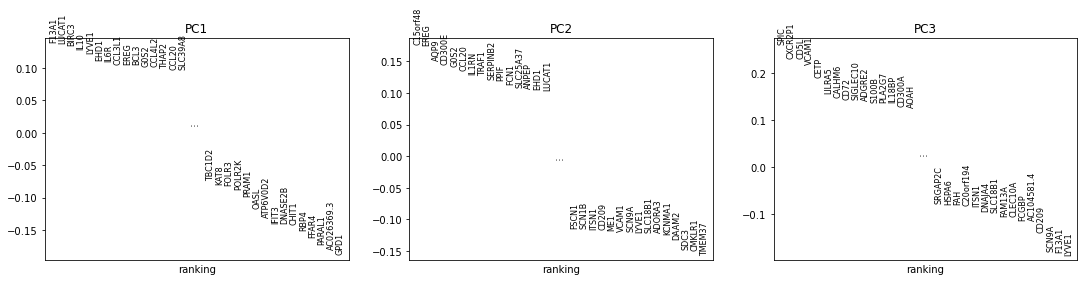

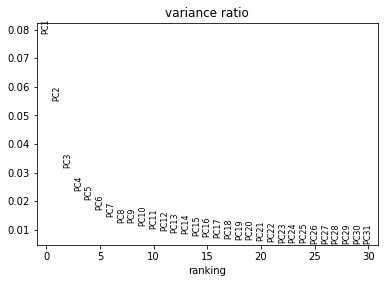

In [178]:
sc.pp.scale(adata)

sc.pp.pca(adata)

sc.pl.pca_overview(adata, color = ['tissue'], projection = '2d', size = 3)

Trying to set attribute `.uns` of view, copying.


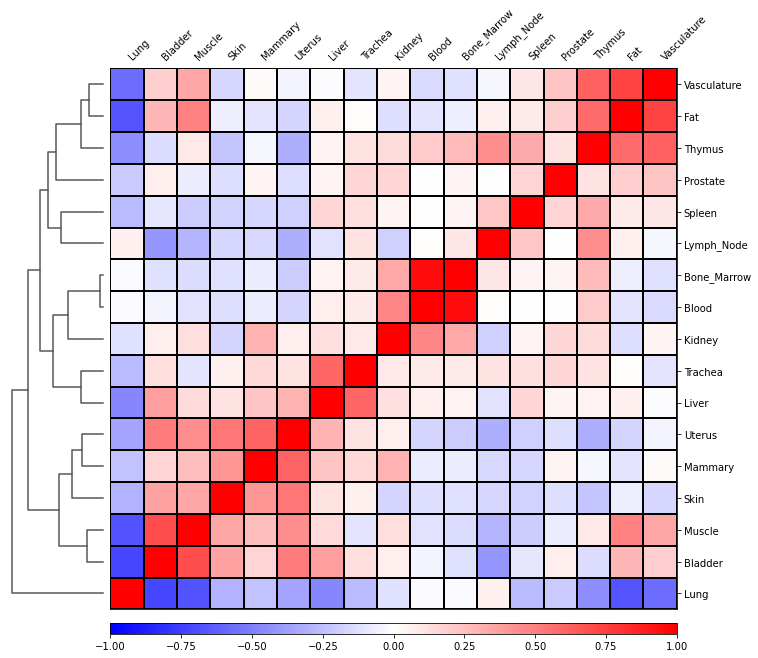

In [183]:
sc.pl.correlation_matrix(adata[:,adata.var.highly_variable == True], groupby='tissue', save='_tissue_macrophage')

In [138]:
dfr = sc.get.obs_df(
                adata,
                keys=['tissue'])

pc1 = adata.obsm['X_pca'][:,0]
pc2 = adata.obsm['X_pca'][:,1]
pc3 = adata.obsm['X_pca'][:,2]

dfr['PC1'], dfr["PC2"], dfr["PC3"] = pc1, pc2, pc3

In [139]:
gene_PC1_score = adata.varm['PCs'][:,0]
gene_PC2_score = adata.varm['PCs'][:,1]
gene_PC3_score = adata.varm['PCs'][:,2]

In [140]:
dfc = sc.get.var_df(
                adata,
                keys=['highly_variable'])

In [141]:
dfc['PC1_load'], dfc["PC2_load"], dfc["PC3_load"] = adata.varm['PCs'][:,0], adata.varm['PCs'][:,1], adata.varm['PCs'][:,2]

In [171]:
hvgs = adata.var[adata.var.highly_variable == True].index.to_list()
df = sc.get.obs_df(
                adata,
                keys=hvgs)

In [172]:
df = df * 1000

In [173]:
df

,MTND1P23,MTCO1P12,AL390719.1,IGSF21,RNF19B,CSF3R,DNASE2B,VCAM1,AMPD2,TMIGD3,...,LILRA5,FTLP3,PARAL1,ITSN1,OSM,CFP,CLIC2,DDX3Y,MT-ND6,MT-TP
cell_id,,,,,,,,,,,,,,,,,,,,,
AAACCCACACTCCTGT_TSP6_Liver_NA_10X_1_1,-757.310608,-503.331970,-209.584015,-316.518250,-592.653687,1263.042480,-469.562164,-250.38147,-425.354675,-502.315521,...,1813.706177,-597.080139,-494.504913,-615.500977,1959.005737,-243.088364,-615.92157,2363.476074,1287.482666,-373.878204
AAAGAACAGCCTCTTC_TSP6_Liver_NA_10X_1_1,86.838562,-503.331970,-209.584015,-316.518250,-592.653687,-608.964111,-469.562164,-250.38147,-425.354675,-502.315521,...,1914.118408,-597.080139,-494.504913,1722.072632,2706.814941,-243.088364,1800.65271,1250.989868,-721.711731,-373.878204
AAAGAACGTTTCTTAC_TSP6_Liver_NA_10X_1_1,-757.310608,-503.331970,4294.729980,-316.518250,-592.653687,-608.964111,-469.562164,-250.38147,-425.354675,-502.315521,...,1613.258423,-597.080139,-494.504913,-615.500977,-440.265045,-243.088364,-615.92157,2163.822021,1131.556396,-373.878204
AAAGAACTCTTCTCAA_TSP6_Liver_NA_10X_1_1,-757.310608,-503.331970,-209.584015,-316.518250,2910.341553,1493.449219,-469.562164,-250.38147,2800.813965,-502.315521,...,-517.901367,-597.080139,-494.504913,-615.500977,-440.265045,-243.088364,-615.92157,2603.814697,-721.711731,2554.999023
AAAGGATCACATGAAA_TSP6_Liver_NA_10X_1_1,92.953461,-503.331970,-209.584015,-316.518250,-592.653687,-608.964111,-469.562164,-250.38147,-425.354675,-502.315521,...,-517.901367,-597.080139,-494.504913,1207.315552,-440.265045,-243.088364,-615.92157,-480.340546,449.619110,-373.878204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TSP2_Vasculature_aorta_SS2_B113343_B133091_Immune_P4_S364,601.892761,-0.972291,5288.534668,-316.518250,1283.164917,1900.355225,-469.562164,-250.38147,-425.354675,-502.315521,...,-517.901367,1930.074829,-494.504913,-615.500977,-440.265045,-243.088364,-615.92157,-480.340546,1484.782471,3397.931885
TSP2_Vasculature_aorta_SS2_B113343_B133091_Immune_P5_S365,1339.314819,-503.331970,-209.584015,5467.751465,-592.653687,-608.964111,-469.562164,-250.38147,-425.354675,-502.315521,...,-517.901367,4701.445312,-494.504913,-615.500977,-440.265045,-243.088364,-615.92157,-480.340546,-721.711731,-373.878204
TSP2_Vasculature_aorta_SS2_B113343_B133091_Immune_P6_S366,2571.898193,268.810242,-209.584015,5513.920898,-592.653687,-608.964111,-469.562164,-250.38147,-425.354675,-502.315521,...,-517.901367,4051.863770,-494.504913,-615.500977,-440.265045,-243.088364,-615.92157,-480.340546,3154.159424,3997.609863


In [174]:
cmaps={'tissue':, 'PC1':'RdYlGn', 'gene cluster':'inferno',
        'PC1_load':'gist_heat', 'PC2_load':'rainbow'}

In [175]:
g = nhm(data=df, dfr=dfr, dfc=dfc, figsize=(10, 10), linewidths=0, showxticks=False)

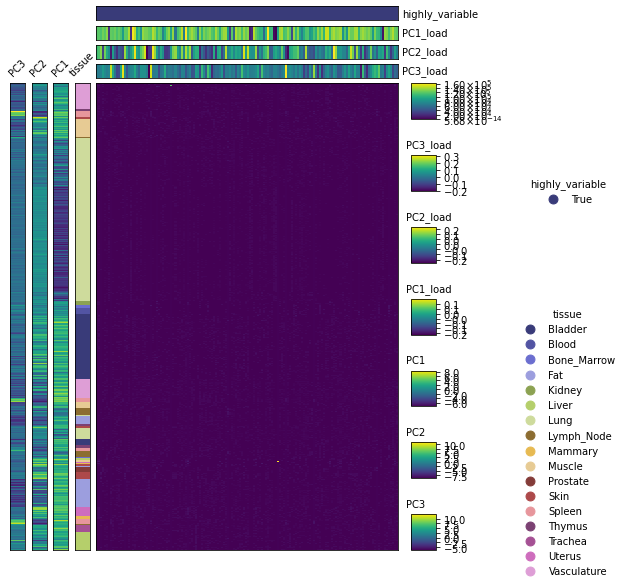

In [176]:
fig, plots = g.run()
